### $Library$

In [233]:
# Torch
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.utils.data as data 
from torch.autograd import Variable

# Machine Learning 
from sklearn.decomposition import PCA


# Numpy 
import numpy as np 
import math 


# Matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
plt.set_cmap('viridis')
%matplotlib inline

# Keras
import tensorflow as tf

# W2V
from gensim.models.word2vec import Word2Vec

# Plotting
import plotly.express as px

# Classes and Parameters
from typing import Optional, Tuple


DEVICE = torch.device("gpu" if torch.cuda.is_available() else "cpu")

### $Embedding \:Layer$

In [116]:
class EmbeddingLayer (nn.Module):
    """ Embedding layer which map and transform tokens into Vectors
    Pad Sequences must have the Same Length"""
    def __init__(self, VocSize:int, EmbDim:int):
        """
        Parameters
        -------------------------------------------------------------
        Args:
            VocSize: Total Unique Words in Corpus: such as tf.keras.text.preprocessing.Tokenizer.word_index
            Emb_Dim : Embedding Dimension to map each of the Given sentences (Original Paper suggests 512)
            
        Return:
            nn.Embedding : shape [batch_size, seq.Length, Emb_Dim]
        """
        super(EmbeddingLayer,self).__init__()
        self.Normalizer = math.sqrt(EmbDim)

        # Embedding Layer : Other Options could be tf.keras.layer.Embedding
        self.EmbLayer = nn.Embedding(num_embeddings = VocSize, embedding_dim = EmbDim)

    def forward (self, x:torch.Tensor)-> nn.Embedding:
        "Return Embedding Matrix , shape : [batch_size, seq.Length, Emb_Dim]"
        # check the notes to understand why Sqrt
        return self.EmbLayer(x) * self.Normalizer 

##### $Embedding \: Example$ : I am using a Embedding = 4, and then using PCA to pass from 4 Dimension to 3 Dimension

In [113]:
import tensorflow as tf
import pandas as pd

# Original Sentences
MySentences = [["Hello", "this", "is", "Marvin"], 
                ["explaining", "attention" ,"is" ,"all" ,"you" ,"need"]]

# Settings Word into Vector 
MinWords , EmbDim , MaxLength = 1, 4,6
INDEX = MySentences[0] + ["<pad>"] * 2 + MySentences[1]
COLS = [f"Dim_{dimension+1}" for dimension in range(EmbDim)]

# Tokenizing and Transforming
Tokenizer = tf.keras.preprocessing.text.Tokenizer()
Tokenizer.fit_on_texts(MySentences)

# Word2Token
W2Token = Tokenizer.texts_to_sequences(MySentences)
Token2Seq = tf.keras.utils.pad_sequences(sequences  = W2Token,maxlen= MaxLength, padding ='post')
print(f"Corpus VocSize : {len(Tokenizer.word_index) + 1}")
print(f"Token2Seq : {list(Token2Seq)}")

Corpus VocSize : 10
Token2Seq : [array([2, 3, 1, 4, 0, 0]), array([5, 6, 1, 7, 8, 9])]


In [114]:
# Initiating and Fitting
EmbeddingLayer_ = EmbeddingLayer(VocSize=len(Tokenizer.word_index) + 1, EmbDim= EmbDim) 
EmbOutput = EmbeddingLayer_(torch.from_numpy(Token2Seq))
print(f"Original Output shape `EmbOutput`; {EmbOutput.size()}")

# Pandas Representation 
Data4Pandas = EmbOutput.view(12,EmbDim).detach().numpy()  # ::atr:: `PCA` Handle 2D Array : Passing From [2 batches, Seq.MaxLength, EmbeddingDimension] -> [2 batches, Seq.MaxLength, EmbeddingDimension]
pd.DataFrame( index = INDEX , data = Data4Pandas, columns = COLS)

Original Output shape `EmbOutput`; torch.Size([2, 6, 4])


,Dim_1,Dim_2,Dim_3,Dim_4
Hello,1.440728,2.973674,-1.430465,0.848117
this,0.541911,-2.988358,0.928725,0.479676
is,0.416919,-1.006722,-1.224518,2.233092
Marvin,0.347694,0.448656,-1.068523,1.702791
<pad>,-0.819999,-2.927366,-1.938664,1.094274
<pad>,-0.819999,-2.927366,-1.938664,1.094274
explaining,1.866949,-1.135921,0.918973,0.535263
attention,-1.573473,1.415533,-0.277066,-0.100730
is,0.416919,-1.006722,-1.224518,2.233092
all,-1.644863,-0.696444,-1.084596,-3.644011


In [115]:
# Reducing Dimensionality for Visualization Passing From 4D to 3D
D3 = PCA(n_components=3)
D3Data = D3.fit_transform(Data4Pandas)
Pandas3D = pd.DataFrame( index = INDEX, data = D3Data, columns = COLS[:-1]) # -1 because I dont need the last columns 

# Plotting W2V
fig = px.scatter_3d(data_frame = Pandas3D, x=COLS[0], y=COLS[1], z=COLS[2],  title="W2V in 3 Dimension", width=700, height=600, text = INDEX)
fig.show()

___________________________________________________

### $Positional \:  Encoding$

1. Positional Encoder doest not depend on the feature of any given word
2. First implement a **PE Matrix** with shape :$${Seq.Length.\times Embedding Dimension}$$
3. Create a **Indexposition** with length equal to $${Seq.Length.}$$ and reshape to $${Size = [Seq.Length, 1]}$$
4. Take the **IndexPosition** , if index % 2 = 0, apply **Sine** Otherwise **Cosine** (Follow the Formula)

\begin{split}PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}\end{split}

In [117]:
class PositionalEncoderLayer (nn.Module):
    """ Generate Positional Encoding 'No trainable'"""
    def __init__(self, EmbDim:int, Dropout:float, MaxLength:int=5000) -> None:
        """
        Parameters
        -------------------------------------------------------------
        Args:
            MaxLength :  Sequence.Length from Embedding Layers. (Original Paper suggests 512)
            Dropout: If a number is given , this dropout would be added at the end of the calculation
            
        Return:
            EmbOutput : Tensor 
     
        """
        super(PositionalEncoderLayer, self).__init__()
        assert (EmbDim % 2 == 0) , "Embedding dimension Must be divisible by 2,two time-steps should be consistent across sentences with different lengths"
        self.Dropout = Dropout
        self.DropoutLayer = nn.Dropout(p = Dropout)

        # Positional Encoder Matrix : Other Codes calls it "pe", shape:[Batch_size, Seq.MaxLength, Emd_Dimension]
        self.PositionEncoder = torch.zeros((1,MaxLength, EmbDim), dtype = torch.float32, device  = DEVICE)

        # Positional Index shape:[Seq.MaxLength, 1]
        self.PositionalIndex = torch.arange(start = 0, end = MaxLength, dtype=torch.float32).reshape(-1,1)

        #Internal Calculations
        self.Position_i = self.PositionalIndex / torch.pow(10000, torch.arange(start = 0, end = EmbDim, step =2)/EmbDim)

        # Replacing Position into Positional Encoder shape:[Batch_size, Seq.MaxLength, Emd_Dimension]
        self.PositionEncoder[:, :, 0::2] = torch.sin(self.Position_i) # Replace [batch_size, all_rows, Even-th Cols]
        self.PositionEncoder[:, :, 1::2] = torch.cos(self.Position_i) # Replace [batch_size, all_rows, Odd-th Cols] 


        # Keep in Memory  
        self.register_buffer("PositionalEncoder", self.PositionEncoder) # No trainable

    def forward(self, X) -> torch.Tensor:
        """
        Args:
            X = must be the Word Vector from Embedding Layer with shape : [batch_size, Seq.MaxLength, Emd_Dimension]
        """


        # [:, X.size(1), :] do this EmbeddingLayer + Positional Encoder
        X = X + self.PositionEncoder[:, :X.shape[1], :].to(DEVICE) # [all batches, rows in batches_size , all columns]

        if (self.Dropout) or (self.Dropout != 0):
            return self.DropoutLayer(X)
        else:
            return X

##### $PE, Pe \: or \: Positional Enconder$



![Matrix](https://miro.medium.com/max/828/1*R3U8xOrxuYRYNLe961n7bg.png)

_____________________________________________________

In [118]:
# Data from Embeddings 
EmbDim , MaxLength = 4,6
FromEmb = EmbOutput # shape [batch_size,MaxLength, EmbDim ] ~ [2,6,4]
StepByStepData = pd.DataFrame( index = INDEX[:6] , data = Data4Pandas[:6,:], columns = COLS[:6]) # Take only the First 6th-Rows and all Dimension 


print(f"shape:{StepByStepData.shape}, row : {StepByStepData.shape[0]}, cols : {StepByStepData.shape[1]}")
StepByStepData

shape:(6, 4), row : 6, cols : 4


,Dim_1,Dim_2,Dim_3,Dim_4
Hello,1.440728,2.973674,-1.430465,0.848117
this,0.541911,-2.988358,0.928725,0.479676
is,0.416919,-1.006722,-1.224518,2.233092
Marvin,0.347694,0.448656,-1.068523,1.702791
<pad>,-0.819999,-2.927366,-1.938664,1.094274
<pad>,-0.819999,-2.927366,-1.938664,1.094274


-------------------------------------------------------

The paper explains that Each word in the corpus is given a index (0 to TotalWordsCorpus) then this index is transformed into binary encoding that is why we need a matrix 
**`PE Matrix`** with shape :$${Seq.Length.\times Embedding Dimension}$$



In [119]:
# We Create a Tensor With Equal Dimension 
PositionalEncoder = torch.zeros(StepByStepData.shape[0], StepByStepData.shape[1])
pd.DataFrame(index = StepByStepData.index, data= PositionalEncoder)

,0,1,2,3
Hello,0.0,0.0,0.0,0.0
this,0.0,0.0,0.0,0.0
is,0.0,0.0,0.0,0.0
Marvin,0.0,0.0,0.0,0.0
<pad>,0.0,0.0,0.0,0.0
<pad>,0.0,0.0,0.0,0.0


##### $Index \ Position$



Now , we have to find the total number of sample by batches known as **Indexposition** with length equal to $${batch.size \times  seq.len.\times   1}$$

![Vector](https://miro.medium.com/max/442/1*22CQ8yD0W97QRg4YW86PGw.png)


![Using Un-Squeeze](https://i.stack.imgur.com/NiJu4.png)

In [120]:
# Creating Index Position
IndexPosition = torch.arange(start = 0, end = len(StepByStepData.index), device= DEVICE)
print(f"Index Position: {IndexPosition} , index goes from 0 to {max(IndexPosition)}")


# Reshaping 
IndexPositionReshape = IndexPosition.reshape(IndexPosition.shape[0],1)
print(f"Index Position shape : {IndexPosition.shape}")
print(f"Index Position Reshaped : {IndexPosition.unsqueeze(1).size()}") # Original Post: https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch

# We use unsqueeze(1) : to add one extra dimmension to each row
pd.DataFrame(IndexPosition.unsqueeze(1))

Index Position: tensor([0, 1, 2, 3, 4, 5]) , index goes from 0 to 5
Index Position shape : torch.Size([6])
Index Position Reshaped : torch.Size([6, 1])


,0
0,0
1,1
2,2
3,3
4,4
5,5


##### $Transformation $



Take the **IndexPosition Matrix indices**, if index % 2 = 0, apply **Sine** Otherwise **Cosine** (Follow the Formula)

\begin{split}PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}\end{split}

where **d_model** = **Embedding Dimension** , **i** = **IndexPosition** and **pos** is the position in the Indexposition Matrix
there for even-th index will be encoded using Sin, and odd-th will be encoded with cosine


In [121]:
for pos in range(0,MaxLength): 
    for i in range(0,EmbDim):
        if i % 2 == 0:
            PositionalEncoder[pos, i] = np.sin(pos/10000**(i/EmbDim))
        if i % 2 == 1:
            PositionalEncoder[pos, i] = np.cos(pos/10000**(i/EmbDim))

pd.DataFrame(index = StepByStepData.index, data = PositionalEncoder)


,0,1,2,3
Hello,0.000000,1.000000,0.000000,1.000000
this,0.841471,0.995004,0.010000,1.000000
is,0.909297,0.980067,0.019999,0.999998
Marvin,0.141120,0.955337,0.029996,0.999996
<pad>,-0.756802,0.921061,0.039989,0.999992
<pad>,-0.958924,0.877583,0.049979,0.999987


##### $Plotting \ {Sin} \ and\ {Cosine} $ : Using Internal Positional Encoder + Embedding and New Postional Embedding (for visualization only)

-  Displaying with Embedding of 0, to check Sin, Cos 
-  Create use the previous Embedding and check the Transformation 

Text(0.5, 1.0, 'Sin Cos Using Positional Encoder Only')

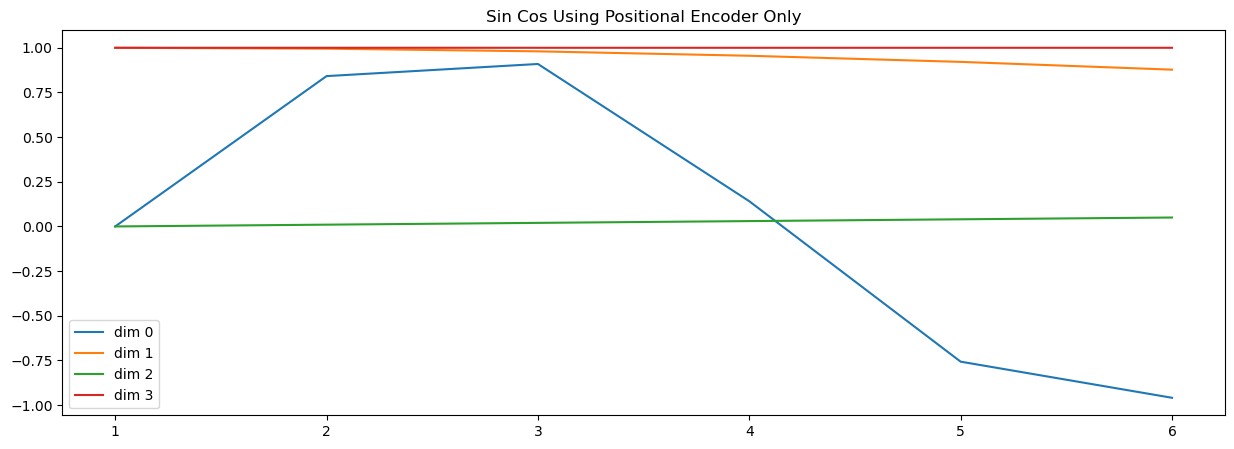

In [122]:
# 2D plotting 
plt.figure(figsize=(15, 5))
plt.plot(np.arange(MaxLength)+1, PositionalEncoder[:,:].data.numpy())
plt.legend(["dim %d"%p for p in range(4)])
plt.title("Sin Cos Using Positional Encoder Only")

Note : The Tensor used to fit the Embedding Layer is only a matrix of Zeros, therefore nothing is added to the Positional Encoder that is why is going from -1 to +1

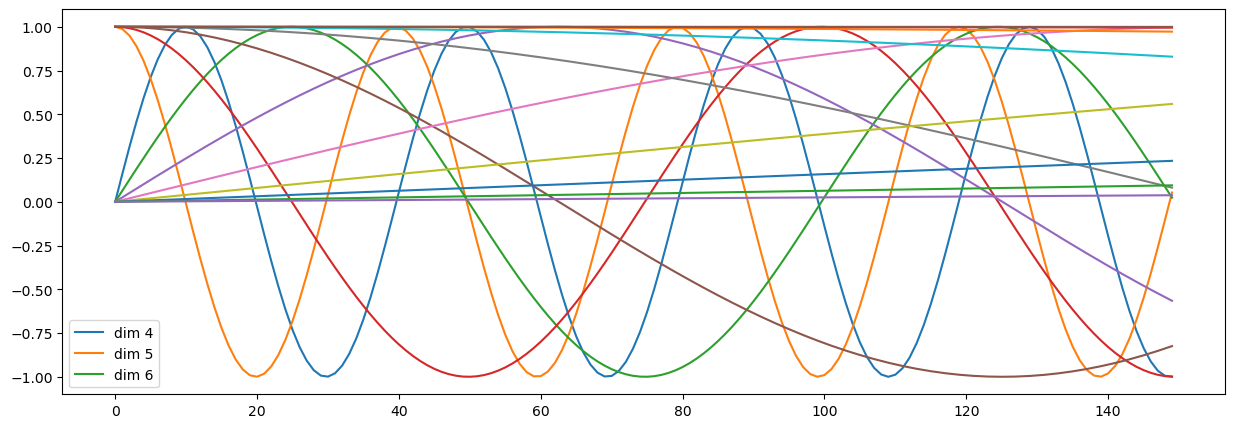

In [123]:
# Testing with a embedding composed of 
batch, dimension = 1, 20
vc_size = 150

SinCosPosEnc = PositionalEncoderLayer(EmbDim =dimension,  Dropout =0.0 , MaxLength=150)
SinCosPosEncOuput = SinCosPosEnc(torch.zeros(batch, vc_size, dimension)) # Embedding  nn.Embedding(num_embeddings = VocSize, embedding_dim = Emb_Dim)


# Plotting 
plt.figure(figsize=(15, 5))
plt.plot(np.arange(vc_size), SinCosPosEncOuput[0, :,4:].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6]]);

In here we are Evaluating the PositionalEncoderLayer , which is fit with the Embedding Output

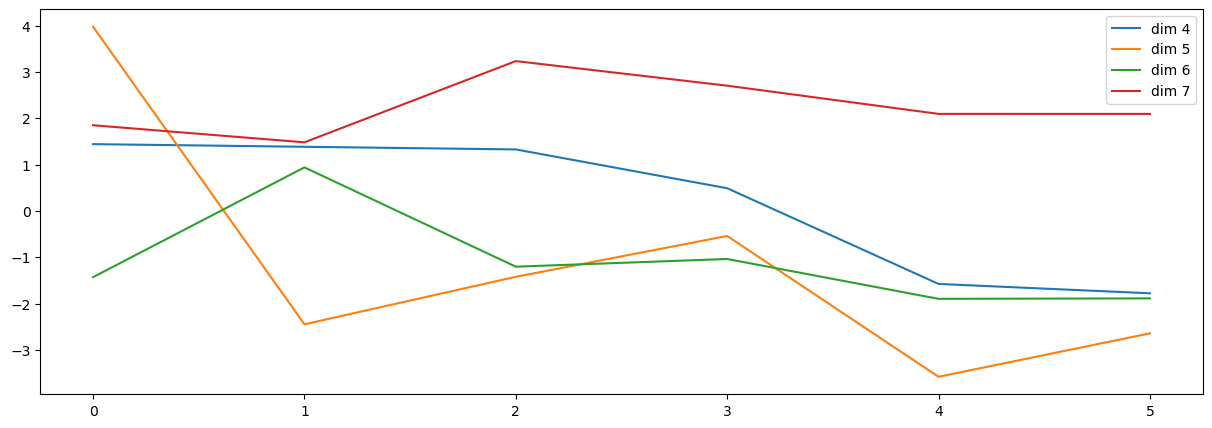

In [124]:
# Testing with a embedding composed of 

PosEnc = PositionalEncoderLayer(EmbDim =EmbDim,  Dropout =0.0 , MaxLength=MaxLength)
OutPosEnc = PosEnc(FromEmb) # Embedding  nn.Embedding(num_embeddings = VocSize, embedding_dim = Emb_Dim)


# Plotting 
plt.figure(figsize=(15, 5))
plt.plot(np.arange(MaxLength), OutPosEnc[0, :, :].data.numpy())

plt.legend(["dim %d"%p for p in [4,5,6,7,8]]);

#### $3D\ Graph\ Showing\ the\ Sin\ ,\ Cos\ Wave\ and\ the\ Word\ position$

##### 3D Plotting Large Embedding Model

In [125]:
# Plotting  
SinCosPosEncOutput = pd.DataFrame(index = [f"Word_{n}" for n in range(SinCosPosEncOuput.shape[1])],
                                data = SinCosPosEncOuput.view(150,-1), 
                                columns = [f"Dim_{n}" for n in range(SinCosPosEncOuput.shape[2])]).T
SinCosPosEncOutput

,Word_0,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,...,Word_140,Word_141,Word_142,Word_143,Word_144,Word_145,Word_146,Word_147,Word_148,Word_149
Dim_0,0.0,0.841471,0.909297,0.141120,-0.756802,-0.958924,-0.279415,0.656987,0.989358,0.412118,...,0.980240,0.363171,-0.587795,-0.998345,-0.491022,0.467745,0.996469,0.609044,-0.338333,-0.974649
Dim_1,1.0,0.540302,-0.416147,-0.989992,-0.653644,0.283662,0.960170,0.753902,-0.145500,-0.911130,...,-0.197814,-0.931722,-0.809010,0.057503,0.871147,0.883863,0.083959,-0.793136,-0.941026,-0.223741
Dim_2,0.0,0.387674,0.714713,0.929966,0.999766,0.913195,0.683794,0.347443,-0.043251,-0.427180,...,-0.726808,-0.403697,-0.017447,0.371534,0.702402,0.923410,0.999991,0.920166,0.696419,0.363750
Dim_3,1.0,0.921796,0.699417,0.367644,-0.021631,-0.407523,-0.729675,-0.937701,-0.999064,-0.904166,...,0.686840,0.914893,0.999848,0.928419,0.711780,0.383815,-0.004185,-0.391528,-0.717635,-0.931497
Dim_4,0.0,0.157827,0.311697,0.457755,0.592338,0.712073,0.813960,0.895443,0.954481,0.989594,...,-0.196076,-0.348382,-0.491954,-0.623197,-0.738817,-0.835918,-0.912065,-0.965350,-0.994437,-0.998598
Dim_5,1.0,0.987467,0.950181,0.889079,0.805690,0.702105,0.580922,0.445176,0.298272,0.143891,...,-0.980589,-0.937353,-0.870621,-0.782065,-0.673906,-0.548855,-0.410046,-0.260959,-0.105330,0.052939
Dim_6,0.0,0.063054,0.125857,0.188159,0.249712,0.310272,0.369596,0.427450,0.483602,0.537830,...,0.557504,0.504049,0.448587,0.391342,0.332538,0.272410,0.211199,0.149147,0.086502,0.023513
Dim_7,1.0,0.998010,0.992048,0.982139,0.968320,0.950648,0.929192,0.904039,0.875288,0.843053,...,-0.830174,-0.863675,-0.893739,-0.920245,-0.943090,-0.962181,-0.977443,-0.988815,-0.996252,-0.999724
Dim_8,0.0,0.025116,0.050217,0.075285,0.100306,0.125264,0.150143,0.174927,0.199601,0.224149,...,-0.366317,-0.389572,-0.412581,-0.435330,-0.457804,-0.479989,-0.501872,-0.523438,-0.544673,-0.565565
Dim_9,1.0,0.999685,0.998738,0.997162,0.994957,0.992123,0.988664,0.984581,0.979877,0.974555,...,-0.930490,-0.920996,-0.910921,-0.900271,-0.889053,-0.877274,-0.864942,-0.852064,-0.838649,-0.824704


In [126]:
# Creating Coor for 3D Graphics
Word_i_SinCos = {f"W_{key}":{'x':[],'y':[] ,'z':[]} for _, key in enumerate(SinCosPosEncOutput.index)}
pad_ = 0
for index_, key_ in enumerate(Word_i_SinCos.keys()):
    for position_ in range(len(SinCosPosEncOutput.columns)):
        Word_i_SinCos[key_]['z'].append(SinCosPosEncOutput.iloc[index_,position_])
        Word_i_SinCos[key_]['x'].append(position_)
        Word_i_SinCos[key_]['y'].append(index_)

In [127]:
fig = go.Figure()
f,t = 4,8
for num, key_ in enumerate(list(Word_i_SinCos.keys())[f:t]):
    # Adding Text
    text_ = [f"{key_}Po{position}" for position in range(0,len(SinCosPosEncOutput.columns),2)]

    # Multiplot Scattter3D
    fig.add_scatter3d(x = Word_i_SinCos[key_]['x'],y = Word_i_SinCos[key_]['y'],z = Word_i_SinCos[key_]['z'], text=text_ ,mode='lines+text',name = f"Dimension {num}")

fig.update_layout(autosize=False,width=1400,height=900,)
fig.show()

##### 3D Plotting Using Our Embedding Output

In [128]:
# Plotting  
PositionEncoderOutput = pd.DataFrame(index = INDEX,data = OutPosEnc.view(12,4).detach().numpy(), columns = COLS).T
PositionEncoderOutput

,Hello,this,is,Marvin,<pad>,<pad>,explaining,attention,is,all,you,need
Dim_1,1.440728,1.383382,1.326216,0.488814,-1.576802,-1.778924,1.866949,-0.732002,1.326216,-1.503743,0.510343,-2.673751
Dim_2,3.973674,-2.448056,-1.422869,-0.541337,-3.581009,-2.643703,-0.135921,1.955835,-1.422869,-1.686437,-1.138418,-5.498075
Dim_3,-1.430465,0.938725,-1.204520,-1.038527,-1.898675,-1.888685,0.918973,-0.267066,-1.204520,-1.054601,-3.723803,-1.320194
Dim_4,1.848117,1.479626,3.232892,2.702341,2.093474,2.093024,1.535263,0.899220,3.232892,-2.644461,2.213198,-0.991135


In [129]:
# Creating Coor for 3D Graphics
Word_i_our_embedding = {f"W_{key}":{'x':[],'y':[] ,'z':[]} for _, key in enumerate(PositionEncoderOutput.index)}
pad_ = 0
for index_, key_ in enumerate(Word_i_our_embedding.keys()):
    for position_ in range(len(PositionEncoderOutput.columns)):
        Word_i_our_embedding[key_]['z'].append(PositionEncoderOutput.iloc[index_,position_])
        Word_i_our_embedding[key_]['x'].append(position_)
        Word_i_our_embedding[key_]['y'].append(index_)

In [130]:
fig = go.Figure()
for num, key_ in enumerate(list(Word_i.keys())):
    # Adding Text
    text_ = [f"{INDEX[position]}_Po{position}" for position in range(0,len(PositionEncoderOutput.columns))]

    # Multiplot Scattter3D
    fig.add_scatter3d(x = Word_i_our_embedding[key_]['x'],y = Word_i_our_embedding[key_]['y'],z = Word_i_our_embedding[key_]['z'], text=text_ ,mode='lines+text',name = f"Dimension {num}")

fig.update_layout(autosize=False,width=1400,height=900,)
fig.show()

#### $Wave\ Into\ circumference$ 
- In my limited Understanding the wave are supposed to be displayed in the circumferences and each position the value of a word segmented in N position, think of it like a cluster where each point is a differente representation of the same word but they are the same 

In [131]:
# Trying to project wave into the Circle 
def finding_r (abj_, opos_):
    r_ =  np.sqrt(abj_**2 + opos_**2)
    teta_ = float(opos_)/float(abj_)
    teta_ = np.arctan(teta_) * 180/math.pi
    return r_*np.cos(teta_), r_*np.sin(teta_)

![Sin Cos Wave](https://upload.wikimedia.org/wikipedia/commons/b/bd/Sine_and_cosine_animation.gif)

##### 3D Plotting Sin Cos Circumference (Our Own Embedding)

In [132]:
r1, teta1 = [], []
r2, teta2 = [], []

# Projecting Word_1     
for i in PositionEncoderOutput.T.columns:
    x, y = finding_r(1,PositionEncoderOutput.T.loc[PositionEncoderOutput.T.index[0],i])
    r1.append(x),teta1.append(y)

# Projecting Word_2    
for i in PositionEncoderOutput.T.columns:
    x, y = finding_r(1,PositionEncoderOutput.T.loc[PositionEncoderOutput.T.index[1],i])
    r2.append(x),teta2.append(y)


fig = go.Figure()

# Adding First Word 
fig.add_scatter3d(x = [1]*len(r1) ,y = r1, z= teta1  , text=[f"{PositionEncoderOutput.T.index[0]}_po_{n+1}" for n in range(len(PositionEncoderOutput.index))],mode='markers+text', name=PositionEncoderOutput.T.index[0])

# Adding second Word 
fig.add_scatter3d(x = [2]*len(r2) ,y = r2, z= teta2  , text=[f"{PositionEncoderOutput.T.index[1]}_po_{n+1}" for n in range(len(PositionEncoderOutput.index))],mode='markers+text', name=PositionEncoderOutput.T.index[1])

# Plotting
fig.update_layout(autosize=False,width=1400,height=900,)
fig.show()

##### 3D Plotting Sin Cos Circumference (Large Embedding)

In [ ]:
r1, teta1 = [], []
r2, teta2 = [], []

# Projecting Word_1     
for i in SinCosPosEncOutput.T.columns[1:]:
    x, y = finding_r(1,SinCosPosEncOutput.T.loc[f"Word_{1}",i])
    r1.append(x),teta1.append(y)

# Projecting Word_2    
for i in SinCosPosEncOutput.T.columns[1:]:
    x, y = finding_r(1,SinCosPosEncOutput.T.loc[f"Word_{2}",i])
    r2.append(x),teta2.append(y)


fig = go.Figure()

# Adding First Word 
fig.add_scatter3d(x = [1]*len(r1) ,y = r1, z= teta1  , text=[f"Word1_Po{po}" for po in SinCosPosEncOutput.T.index[1:]],mode='markers+text', name="Word_1")

# Adding second Word 
fig.add_scatter3d(x = [2]*len(r2) ,y = r2, z= teta2  , text=[f"Word2_Po{po}" for po in SinCosPosEncOutput.T.index[1:]],mode='markers+text', name="Word_2")

# Plotting
fig.update_layout(autosize=False,width=1400,height=900,)
fig.show()

Note : These are the projection of Word1 and Word2 into a Sin Cos Circumferences, this might be wrong but I am just trying to imagine how it looks , because I understand things if i can see them.
if you find the right way to display them let me know

----------------------------------------------------------------------------------------------------------------------------------------

###  $Embedding + Positional \ Encoder$

In [134]:
# Applying Positional Encoder
Positional = PositionalEncoderLayer(EmbDim=EmbDim, Dropout=0.0)
PositionalOut = Positional(OutPosEnc)

print(f"Positional Encoder + Embedding = {PositionalOut.size()}")
pd.DataFrame(index= INDEX,  data = PositionalOut.reshape(12,-1).detach().numpy())

Positional Encoder + Embedding = torch.Size([2, 6, 4])


,0,1,2,3
Hello,1.440728,4.973674,-1.430465,2.848117
this,2.224853,-1.907754,0.948724,2.479576
is,2.235514,-1.839015,-1.184521,4.232692
Marvin,0.629934,-1.531329,-1.008532,3.701891
<pad>,-2.333604,-4.234653,-1.858686,3.092674
<pad>,-2.737848,-2.360041,-1.838706,3.091774
explaining,1.866949,0.864079,0.918973,2.535263
attention,0.109469,2.496138,-0.257067,1.899170
is,2.235514,-1.839015,-1.184521,4.232692
all,-1.362623,-2.676429,-1.024605,-1.644911


####  $Plotting: \ Embedding\ versus \ "Embedding\ + \ Positional\:Encoder"$

--------------------------------------------------------------------------------

In [135]:
Data4Pandas # This is the output of the Embedding layer , already reshape and detach
PositionalOut # This is the Positional Encoder Output , [batch_size, Seq.Maxlegth, EmbDim] -> torch.Tensor
print("------------------------------- Continue -------------------------------")

------------------------------- Continue -------------------------------


--------------------------------------------------------------------------------------------------------

the blue point are the original embedding position and the red ones are the new position that is the outcome of Encoder +  Embedding However they are not a single point but many of them in different position around the same point

In [ ]:
# Reducing Dimensionality  
D3 = PCA(n_components=3)
D3 = D3.fit(Data4Pandas) # Only Fit because this will be used to transformed The Positional Encoder

# Transforming - Creating Pandas for Visualization Purpose
EmbOut3D = pd.DataFrame( index = INDEX,data =  D3.transform(Data4Pandas)) # Embout :  Output from the Embedding
EmbEnc3D = pd.DataFrame( index = INDEX,data =  D3.transform(PositionalOut.reshape(12,-1).detach().numpy())) # EmbEnc3D : Embedding + Encoder

# Plotting W2V
fig = go.Figure()
fig.add_scatter3d (x =EmbOut3D[0], y=EmbOut3D[1], z=EmbOut3D[2],  name="Embedding", mode='markers+text', text = EmbOut3D.index)
fig.add_scatter3d (x =EmbEnc3D[0], y=EmbEnc3D[1], z=EmbEnc3D[2],  name="Encoder+Embedding", mode='markers+text', text = EmbEnc3D.index)


fig.update_layout(autosize=False,width=1400,height=900,)
fig.show()



In [137]:
# Parameters
f,t = 0,4 # f: First Word, t: Last word


# Projecting Word f ~ Word ~ t , # WRx: Word and Radio x, WT0: Word and Teta x , WTxt0: Word and Text x
WR0, WT0, WTxt0 = [], [], [] 
WR1, WT1, WTxt1 = [], [], []
WR2, WT2, WTxt2 = [], [], []

for i in range(len(EmbEnc3D.index)):
    x, y = finding_r(1,EmbEnc3D.iloc[i,1])
    WR0.append(x),WT0.append(y), WTxt0.append(f"{EmbEnc3D.index[0]}_pos{i}")

    x, y = finding_r(1,EmbEnc3D.iloc[i,1])
    WR1.append(x),WT1.append(y), WTxt1.append(f"{EmbEnc3D.index[1]}_pos{i}")

    x, y = finding_r(1,EmbEnc3D.iloc[i,2])
    WR2.append(x),WT2.append(y), WTxt2.append(f"{EmbEnc3D.index[2]}_pos{i}")


# Lines Embeddings
lines = {word:{} for word in EmbEnc3D.index}
for idx, word in enumerate(EmbEnc3D.index):
    for col in EmbEnc3D.columns:
        lines[word].update({f"po_{col}":{'x':[],'y':[],'z':[]}})


for idx_, word in enumerate(lines.keys()):
    for num, pos_ in enumerate(lines[word].keys()):
        if num == 0 :
            radio_, teta_ = WR0, WT0
        elif num == 1 :
            radio_, teta_ = WR1, WT1
        else:
            radio_, teta_ = WR2, WT2
  

        # Imputing X Embeddings
        lines[word][pos_]['x'].extend((EmbEnc3D.iloc[idx_,0] , num))
        lines[word][pos_]['y'].extend((EmbEnc3D.iloc[idx_,1], radio_[idx_]))
        lines[word][pos_]['z'].extend((EmbEnc3D.iloc[idx_,2] , teta_[idx_]))

print("-------------------------------------- Lines Coordinates Created --------------------------------------")

-------------------------------------- Lines Coordinates Created --------------------------------------


In [ ]:
fig = go.Figure()

# Adding Embedding  +  Encoder 
fig.add_scatter3d (x =EmbEnc3D[0], y=EmbEnc3D[1], z=EmbEnc3D[2],  name="Encoder+Embedding", mode='markers+text', text = EmbOut3D.index,marker=dict(size=10))

# Adding Line 
for Word in list(lines.keys())[f:t]:
    for num, WordPostition in enumerate(lines[Word].keys()):
        fig.add_scatter3d(x = lines[Word][WordPostition]['x'] ,
        y = lines[Word][WordPostition]['y'] ,
         z= lines[Word][WordPostition]['z'],
          marker=dict(size=5),
           mode='markers+text+lines',
           text =[None,f"{Word}_Pos_{num}"],
           showlegend=False)



# Plotting
fig.update_layout(autosize=False,width=1400,height=900,)
fig.show()


Note: The graph is not perfect and perhaps the word representation position is not the best one (because the model has not been trained).
The blue dots are the Embedding + Positional Encoding , however due to the Sinusoidal and Cosinusoidal transformation each word now has different vector positions in a space but they all the same (is like a cluster).

- If I have the Sentences "Hello this is Marvin" and if I want to measure the cosine similarity in between 'Marvin' and 'this' , I have to remember that `this` is position 2, and `Marvin` position 5, but because they all have equal number of position I should measure the word `this_position_5` vs `Marvin_pos_5` or `this_position_2` vs `Marvin_pos_2`

----------------------------------------------

###  $Attention\ Mechanism $

![self-attention](https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/8e3cdc490c4425606cdf1d0cbf229f86bc8173e6/document/images/self-attention.png)

![dimension](https://i.stack.imgur.com/Ogb7B.png)

In [139]:
def AttentionUnit (Q: torch.Tensor, K : torch.Tensor, V : torch.Tensor, mask = None, dropout = None) -> torch.Tensor:
    """
    Compute scaled dot product, 'Note: Q, K, V : are the same Tensor before computation is done'

    Parameters
    -------------------------------------------------------------------------------------
        
    Args:
        Q : Query,
        K : Keys,
        V: Values, 
        mask : Mask for Decoder Block
        dropout : dropout setting 
        
    Return:
    --------------------------------------------------------------------------------
        
        Attention : Final Matrix Multiplication 
       
    """

    # Model Dimension 
    d_k = Q.size(-1) # take the last Dimension of the input : [batch_size, Seq.Maxlength, Emb_dimension]
    K_Transpose = K.transpose (-2,-1) # k.T (transpose) can be used as well but check the Documentation
    QKMatMul = torch.matmul(Q, K_Transpose)
    Scale = QKMatMul / math.sqrt(d_k)  # Inner part of the Formula 

    if mask is not None:
        Scale = Scale.mask_filled(mask == 0, -1e9) # check the mask Section
    
    # Applying soft-max "check the image above : [batch_size : dim0 or dim-3; Seq.Maxlength : dim 1 or dim -2, Emb_dimension : dim 2 or dim -1]
    AttentionMask = torch.nn.functional.softmax(Scale, dim=-1)  

    if dropout is not None:
        AttentionMask = nn.Dropout(p=dropout)(AttentionMask)
    
    AttentionOutput = torch.matmul(AttentionMask, V) # Last part of the Equation softmax(attention) x Values (Matrix)
    return AttentionOutput, AttentionMask

##### $Self \ Attention \ Unit: \ Step \ by \ Step$

- I will use a pre-train Embedding model "WORD2VECTOR", using the same Sentences to get the Word-Vector and pass it to the Self Attention unit

![scaled dot-product self-attention](https://images.prismic.io/peltarionv2/a7445eec-3dd8-4e62-948c-e3c3f9b3a987_self-attention_head.svg?auto=compress%2Cformat&rect=0%2C0%2C148%2C150&w=1720&h=1743)

In [140]:
# Loading Model 
MySentences = [INDEX]
Model = Word2Vec(MySentences, vector_size =4,min_count=1,window=6)

W2V = []
for word in INDEX:
    W2V.append(Model.wv.get_vector(word))

W2VEmbedding = pd.DataFrame(W2V, index = INDEX)
W2VEmbedding

,0,1,2,3
Hello,0.201936,-0.148272,0.001129,-0.118843
this,0.238490,-0.182981,-0.058415,-0.048524
is,-0.232574,-0.177920,0.161472,0.224325
Marvin,-0.188041,-0.098403,-0.187790,-0.023251
<pad>,-0.013406,0.005911,0.127584,0.225232
<pad>,-0.013406,0.005911,0.127584,0.225232
explaining,0.158772,-0.085134,-0.023660,0.144214
attention,0.182794,0.126757,0.168942,0.019072
is,-0.232574,-0.177920,0.161472,0.224325
all,0.071918,0.024798,-0.207142,-0.236233


In [141]:
# Initiating Positional Encoder
PosEnc = PositionalEncoderLayer(EmbDim = W2VEmbedding.shape[1], Dropout = 0)
PosEncOut = PosEnc(torch.from_numpy(W2VEmbedding.values.reshape(2,6,4)))  # Values to get number, shape to change into batches and from_numpy to transform into Tensors

In [142]:
# Outcome from Embedding +  Encoder 
print(f"Positional Encoder + Embedding Original size = {PosEncOut.size()}")
pd.DataFrame(index= INDEX,  data = PosEncOut.reshape(12,-1).detach().numpy() * math.sqrt(4))

Positional Encoder + Embedding Original size = torch.Size([2, 6, 4])


,0,1,2,3
Hello,0.403872,1.703455,0.002258,1.762313
this,2.159921,0.714643,-0.096831,1.902852
is,1.353447,-1.188134,0.362941,2.448249
Marvin,-0.093842,-2.176790,-0.315588,1.952598
<pad>,-1.540416,-1.295466,0.335146,2.448864
<pad>,-1.944660,0.579146,0.355126,2.447964
explaining,0.317544,1.829732,-0.047320,2.288429
attention,2.048530,1.334118,0.357884,2.038043
is,1.353447,-1.188134,0.362941,2.448249
all,0.426077,-1.930389,-0.354292,1.526633


In [143]:
# Taking Q, V, K Dimension (Q=K=V)
Q_= K = V = PosEncOut
d_k_ = PosEncOut.size(-1) # take the last Dimension of the input : [batch_size, Seq.Maxlength, Emb_dimension]
d_k_

4

In [144]:
# K_Transpose

K_Transpose = PosEncOut.transpose(-2,-1)

# K Transpose # Notice This step is applied to each Batch
pd.DataFrame(index=np.arange(0,4),  data = PositionalOut.reshape(12,-1).transpose(-2,-1).detach().numpy(), columns=INDEX)

,Hello,this,is,Marvin,<pad>,<pad>,explaining,attention,is,all,you,need
0,1.440728,2.224853,2.235514,0.629934,-2.333604,-2.737848,1.866949,0.109469,2.235514,-1.362623,-0.246460,-3.632675
1,4.973674,-1.907754,-1.839015,-1.531329,-4.234653,-2.360041,0.864079,2.496138,-1.839015,-2.676429,-1.792061,-5.214413
2,-1.430465,0.948724,-1.184521,-1.008532,-1.858686,-1.838706,0.918973,-0.257067,-1.184521,-1.024605,-3.683814,-1.270214
3,2.848117,2.479576,4.232692,3.701891,3.092674,3.091774,2.535263,1.899170,4.232692,-1.644911,3.212399,0.007615


In [145]:
# QKMatMul 
QKMatMul_ = torch.matmul(Q_, K_Transpose) / math.sqrt(d_k_)
QKMatMul_

tensor([[[ 0.7713,  0.6804,  0.3548, -0.0382,  0.1859,  0.5645],
         [ 0.6804,  1.1008,  0.8372,  0.2485,  0.0468,  0.1047],
         [ 0.3548,  0.8372,  1.1711,  0.8907,  0.6964,  0.3503],
         [-0.0382,  0.2485,  0.8907,  1.0824,  0.9550,  0.4487],
         [ 0.1859,  0.0468,  0.6964,  0.9550,  1.2700,  1.0449],
         [ 0.5645,  0.1047,  0.3503,  0.4487,  1.0449,  1.2795]],

        [[ 1.0860,  0.9673,  0.4802,  0.0142,  0.2535,  0.5473],
         [ 0.9673,  1.2823,  0.7884,  0.1603, -0.1303,  0.0182],
         [ 0.4802,  0.7884,  1.1711,  0.8099,  0.4274,  0.1859],
         [ 0.0142,  0.1603,  0.8099,  0.7955,  0.5149,  0.1388],
         [ 0.2535, -0.1303,  0.4274,  0.5149,  0.9568,  0.8738],
         [ 0.5473,  0.0182,  0.1859,  0.1388,  0.8738,  1.0945]]])

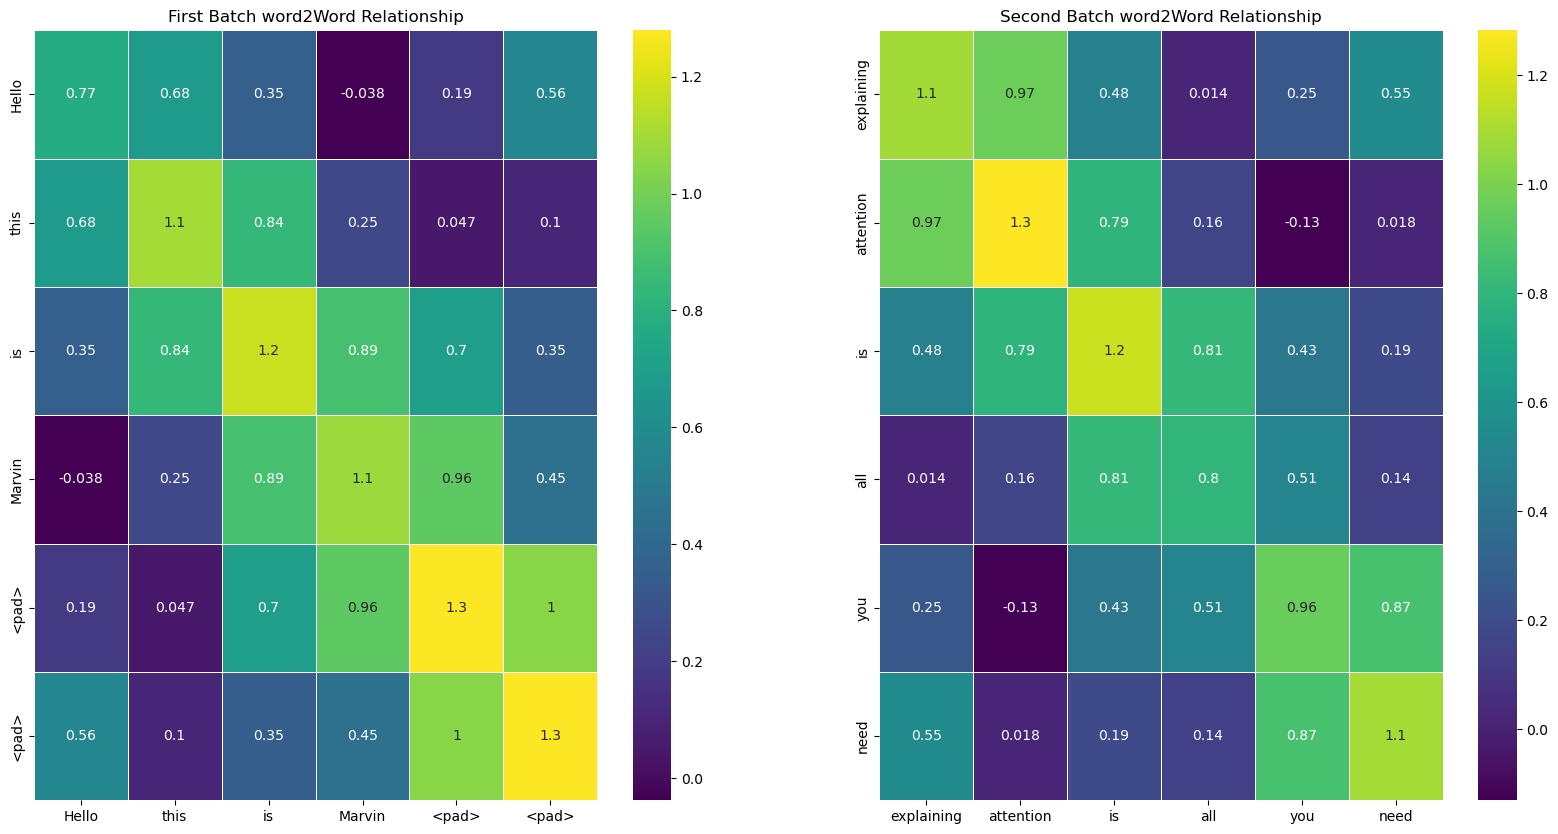

In [146]:
fig, ax = plt.subplots(nrows =1 , ncols =2, figsize =  (20,10))

# ==== First MatMul Before Softmax ====

# First Batch 
sns.heatmap(QKMatMul_[0].detach().numpy(), ax=ax[0], xticklabels=INDEX[:6], yticklabels=INDEX[:6] ,annot=True, linewidth=.5, cmap='viridis')
ax[0].set_title("First Batch word2Word Relationship"); 

# 2nd Batch 
sns.heatmap(QKMatMul_[1].detach().numpy(), ax=ax[1], xticklabels=INDEX[6:], yticklabels=INDEX[6:] ,annot=True, linewidth=.5,cmap='viridis')
ax[1].set_title("Second Batch word2Word Relationship"); 

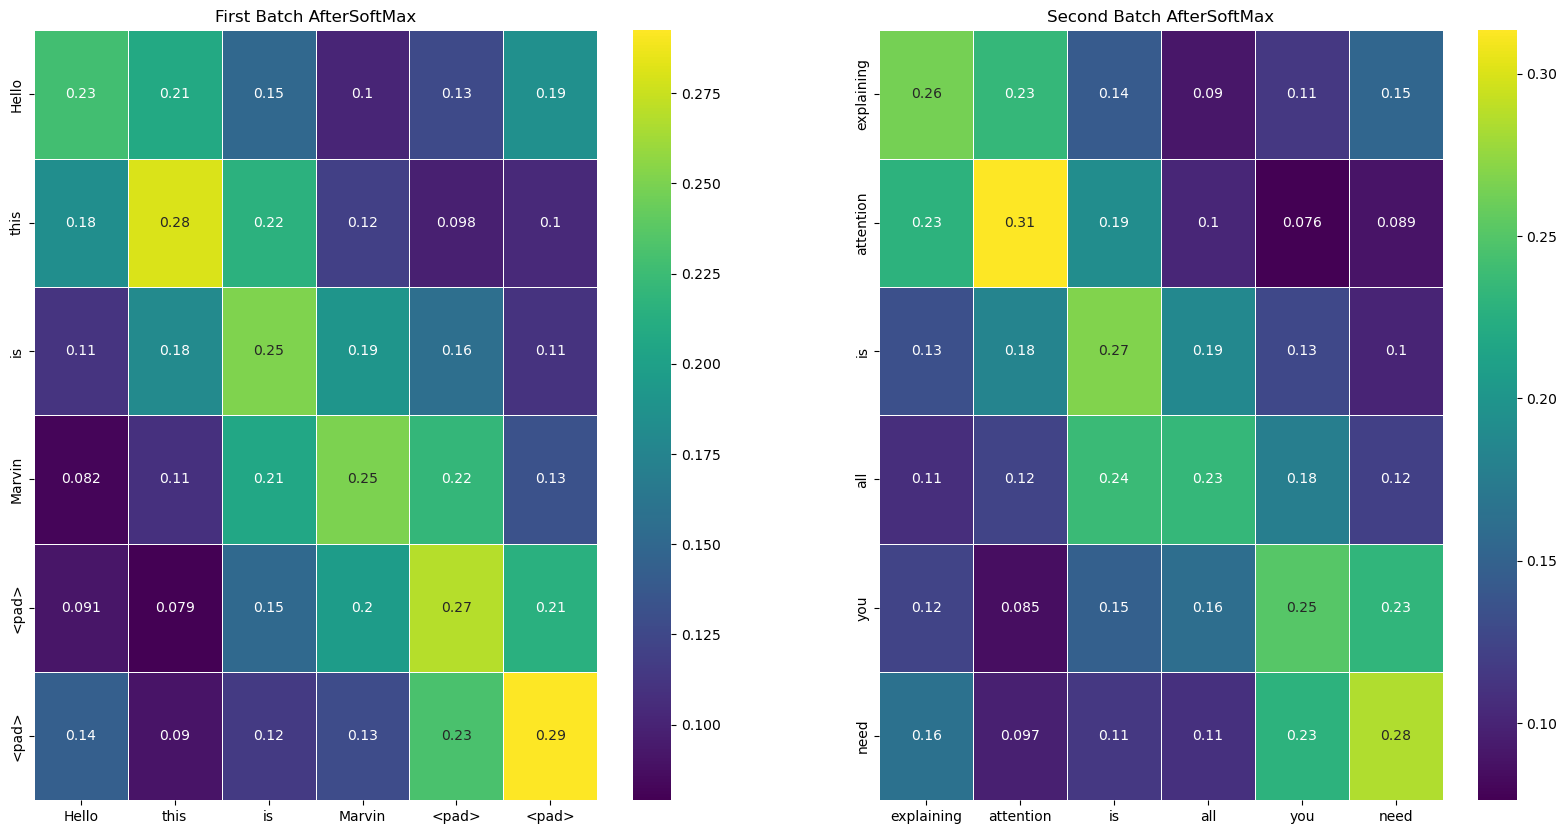

In [147]:
# Applying Softmax 
AfterSoftMax = torch.nn.functional.softmax(QKMatMul_, dim=-1)

fig, ax = plt.subplots(nrows =1 , ncols =2, figsize =  (20,10))

# ==== Softmax ====

# First Batch 
sns.heatmap(AfterSoftMax[0].detach().numpy(), ax=ax[0], xticklabels=INDEX[:6], yticklabels=INDEX[:6] ,annot=True, linewidth=.5, cmap='viridis')
ax[0].set_title("First Batch AfterSoftMax"); 

# 2nd Batch 
sns.heatmap(AfterSoftMax[1].detach().numpy(), ax=ax[1], xticklabels=INDEX[6:], yticklabels=INDEX[6:] ,annot=True, linewidth=.5,cmap='viridis')
ax[1].set_title("Second Batch AfterSoftMax"); 

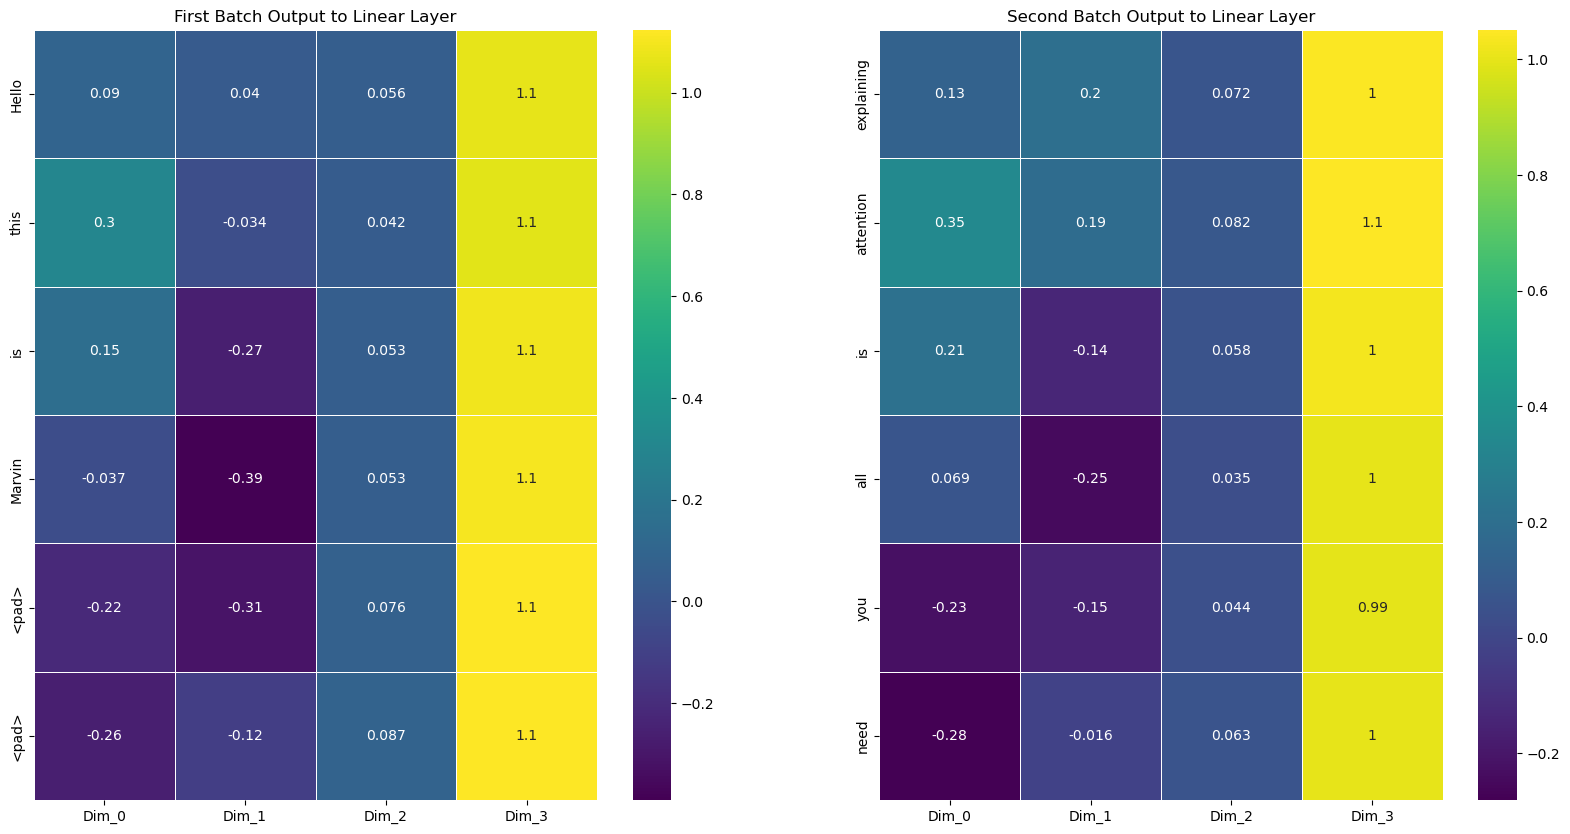

In [149]:
# Multiplying by Values at the end of the Attention Block 
UnitAttentionOut = torch.matmul(AfterSoftMax, V)

fig, ax = plt.subplots(nrows =1 , ncols =2, figsize =  (20,10))

# ==== Softmax ====

# First Batch 
sns.heatmap(UnitAttentionOut[0].detach().numpy(), ax=ax[0], xticklabels=[f"Dim_{n}" for n in range(0,4)], yticklabels=INDEX[:6] ,annot=True, linewidth=.5, cmap='viridis')
ax[0].set_title("First Batch Output to Linear Layer"); 

# 2nd Batch 
sns.heatmap(UnitAttentionOut[1].detach().numpy(), ax=ax[1], xticklabels=[f"Dim_{n}" for n in range(0,4)], yticklabels=INDEX[6:] ,annot=True, linewidth=.5,cmap='viridis')
ax[1].set_title("Second Batch Output to Linear Layer"); 

##### $Multi \ Head \ Attention: \ Step \ by \ Step$

$ \mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ...,
\mathrm{head_h})W^O    \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)$

Where: 


\begin{align}
W_i^Q & \in \mathbb{R}^{d_\text{model} \times d_k}, \\
W_i^K & \in \mathbb{R}^{d_\text{model} \times d_k}, \\
W_i^V & \in \mathbb{R}^{d_\text{model} \times d_v}, \\
W_i^O & \in \mathbb{R}^{hd_v \times d_{\text{model}}}.
\end{align}


**Understading 4 Dimension Tensor**


![4Dimension](https://i.stack.imgur.com/1gypX.png)


In [247]:
class MultiHeadAttentionLayer(nn.Module):
    """ Multi-Head Attention"""
    def __init__ (self, emb_dim:int, heads:int, dropout :float = 0.1)-> None:
        """ General Multihead Attention
        
        Paramaters
        ---------------------------------------------------------------
        
        Args:
            emb_dim: Number of Dimension in Embedding Layer
            heads :  Number of Self-Attention Heads
            dropout: dropout settings
        
        Return 
        ---------------------------------------------------------------
            LinearOuput : Multi-head attention concatenated
        
        """
        super(MultiHeadAttentionLayer,self).__init__()
        assert (heads % 2 == 0), f"Number of head must be divisible by 2, given {heads} is not"
        self.emb_dim = emb_dim
        self.heads = heads
        self.d_k = emb_dim // heads # Head size
        self.dropout = dropout
        self.QKVO_Weight = nn.ModuleList(nn.Linear(in_features = self.emb_dim, out_features = self.emb_dim) for _ in range(4))

        # Reset Weights at starting each block 
        self._ResetParameters() # YOu can check this explanation : https://www.youtube.com/watch?v=tYFO434Lpm0

    def _ResetParameters(self, mask:torch.Tensor = None) -> None:
        """ Initiate Weights and bias"""
        for param_ in self.QKVO_Weight:
            # Initiating Weights
            nn.init.xavier_uniform_(tensor = param_.weight)

            # Initiating Bias
            param_.bias.data.fill_(0)
            

    def forward(self, X:torch.Tensor, mask: Optional[torch.Tensor] = None, return_attention:Optional[bool]=False)-> torch.Tensor:

        if mask is not None:
            mask = mask.unsqueeze(1)

        # Dimension
        nbatch_ = X.size(0) # batch_size

        # Separate Q, K, V from linear output
        Q_ = K_ = V_ = X

        # Linear Calculations and Reshaping : -----------------> Check the Explanation <---------------------------
        Q_, K_, V_ = [Linear_(X_).view(nbatch_, -1, self.heads, self.d_k).transpose(1, 2)  for Linear_, X_ in zip(self.QKVO_Weight, (Q_, K_, V_))]

        # Apply attention on all the projected vectors in batch.
        X, self.attn = AttentionUnit(Q= Q_ , K= K_,  V=V_,  mask = mask, dropout=self.dropout)

        # Contenating Batches 
        X = X.transpose(1,2).contiguous().view(nbatch_, -1, self.heads * self.d_k)

        Output = self.QKVO_Weight[-1](X) # self.QKVO_Weight[-1] refers to the last Matrix Weight created at init which is "Weight for Wo"

        if return_attention:
            return Output, self.attn
        else:
            return Output



In [227]:
class MultiHeadAttention1(nn.Module):
    def __init__(self, d_model=4, num_heads=2, dropout=0.3):
        super().__init__()

        # d_q, d_k, d_v
        self.d = d_model//num_heads


        self.d_model = d_model
        self.num_heads = num_heads

        self.dropout = nn.Dropout(dropout)

        ##create a list of layers for K, and a list of layers for V
        
        self.linear_Qs = nn.ModuleList([nn.Linear(d_model, self.d)
                                        for _ in range(num_heads)])
        self.linear_Ks = nn.ModuleList([nn.Linear(d_model, self.d)
                                        for _ in range(num_heads)])
        self.linear_Vs = nn.ModuleList([nn.Linear(d_model, self.d)
                                        for _ in range(num_heads)])

        self.mha_linear = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # shape(Q) = [B x seq_len x D/num_heads]
        # shape(K, V) = [B x seq_len x D/num_heads]

        Q_K_matmul = torch.matmul(Q, K.permute(0, 2, 1))
        scores = Q_K_matmul/math.sqrt(self.d)
        # shape(scores) = [B x seq_len x seq_len]
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)
        # shape(attention_weights) = [B x seq_len x seq_len]

        output = torch.matmul(attention_weights, V)
        # shape(output) = [B x seq_len x D/num_heads]

        return output, attention_weights

    def forward(self, pre_q, pre_k, pre_v, mask=None):
        # shape(x) = [B x seq_len x D]

        Q = [linear_Q(pre_q) for linear_Q in self.linear_Qs]
        K = [linear_K(pre_k) for linear_K in self.linear_Ks]
        V = [linear_V(pre_v) for linear_V in self.linear_Vs]
        # shape(Q, K, V) = [B x seq_len x D/num_heads] * num_heads

        output_per_head = []
        attn_weights_per_head = []
        # shape(output_per_head) = [B x seq_len x D/num_heads] * num_heads
        # shape(attn_weights_per_head) = [B x seq_len x seq_len] * num_heads
        
        for Q_, K_, V_ in zip(Q, K, V):
            
            ##run scaled_dot_product_attention
            output, attn_weight = self.scaled_dot_product_attention(Q_, K_, V_, mask)
            # shape(output) = [B x seq_len x D/num_heads]
            # shape(attn_weights_per_head) = [B x seq_len x seq_len]
            output_per_head.append(output)
            attn_weights_per_head.append(attn_weight)

        output = torch.cat(output_per_head, -1)
        attn_weights = torch.stack(attn_weights_per_head).permute(1, 0, 2, 3)
        # shape(output) = [B x seq_len x D]
        # shape(attn_weights) = [B x num_heads x seq_len x seq_len]
        
        projection = self.dropout(self.mha_linear(output))

        return projection, attn_weights

###  $Layer\ Normalization $


\begin{align}
LayerNorm(x)= \alpha \odot \frac{x_{ij}-\mu_{i}}
{\sqrt{\sigma^{2}_{i}+\epsilon}} + \beta \tag{eq.5}
\end{align}

 ${\epsilon}$  is to avoid $0$ division;  ${\alpha, \beta}$ are parameter, ${\odot}$ denotes element-wise product. Normally, we initialize ${\alpha}$ as 1s and ${\beta}$ as 0s.

In [164]:
class NormLayer (nn.Module):
    """ Normalization by Layer similar to :attr:`torch.nn.LayerNorm` from pytorch"""
    def __init__(self, input_shape:torch.Tensor, eps:float = 1e-05)-> None:
        """ 
        Parameters
        ---------------------------------------------------------
            Args:
                input_shape: input_shape usually Emb_model
                eps: value for numerical stability 
        """

        super(NormLayer, self).__init__()
        self.alpha = nn.Parameter(torch.ones(input_shape))
        self.beta = nn.Parameter(torch.zeros(input_shape))
        self.eps = eps

    def forward (self, X):
        mean_ = X.mean(-1, keepdim = True) # apply to Rows only
        std_ = X.std(-1, keepdim = True) # apply to Rows only
        X_Zscore = ( X - mean_) / torch.sqrt( std_**2 + self.eps)
        return self.alpha * X_Zscore + self.beta

In [165]:
class AddNormLayer (nn.Module):
    """ Handle the :attr:`Residual Connection`"""
    def __init__(self, input_shape:torch.Tensor, dropout:float=0.01)-> None:
        """ 
        Args:
            input_shape: input_shape: input_shape usually Emb_model
        """
        super(AddNormLayer, self).__init__()
        self.NormLayer_ = nn.LayerNorm(normalized_shape = input_shape)
        self.dropout = nn.Dropout(p = dropout)
    
    def forward (self, X:torch.Tensor, residual:torch.Tensor):
        """ Add ClosesInput to SkippedConnection and then apply Layer Normalization and dropout if it is given
        Args:
            ClosesInput: Closes Connection to this Layer
            SkippedConnection: skipped connection to be added to the layer"""

        LN = self.NormLayer_(X + residual)
        return self.dropout(LN)

###  $Feed\ Forward $

In [183]:
class FeedForwardLayer(nn.Module):
    """ FeedForward Layer """

    def __init__(self,Emb_dim:int, OutputShape :int, dropout:float=0.01)-> None:
        super(FeedForwardLayer,self).__init__()
        self.Emb_dim = Emb_dim
        self.OutputShape = OutputShape
        self.dropout = nn.Dropout(p = dropout)

        self.FirstLayer = nn.Linear(Emb_dim,OutputShape) # Dimension from AddNormalize Layer: shape [Seq.MaxLength, Emd_dim]
        self.SecondLayer = nn.Linear(OutputShape,Emb_dim) # Output send to Multi-head Attention shape: shape [Emd_dim, Seq.MaxLength]
        self.RELU = nn.ReLU() # https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html


    def forward(self, X):
        Layer1 = self.FirstLayer(X)
        Activation = self.dropout(self.RELU(Layer1))
        Layer2 = self.SecondLayer(Activation)

        return Layer2

In [184]:
TensorToy = torch.rand(1,6,4)

FF = FeedForwardLayer(4,6)
FF(TensorToy)

tensor([[[0.1415, 0.4664, 0.5388, 0.1882],
         [0.1449, 0.3569, 0.4735, 0.1537],
         [0.1581, 0.3162, 0.4977, 0.1504],
         [0.1542, 0.3496, 0.4759, 0.1717],
         [0.1586, 0.3918, 0.5170, 0.1737],
         [0.1698, 0.2922, 0.5265, 0.2012]]], grad_fn=<ViewBackward0>)

###  $Testing $

In [297]:
Input_ = torch.Tensor([[[1,2,3,4],[5,6,7,8],[-1,-2,-3,-4],[-5,-6,-7,-8],[1,-2,3,-4],[-1,2,-3,4]]])
QW = torch.ones(4,4)
input_ = torch.matmul(Input_,QW)
Q = K = V = input_

In [335]:
# Craeting Wegiths
Wq = torch.ones(1,4,4)
Wk = torch.ones(1,4,4) * -1 
Wv = torch.ones(1,4,4) + 1
Wo = torch.Tensor([[[1,0,1,0],[0,1,0,1],[0,0,1,1],[1,1,0,0]]])

In [336]:
WQ = torch.matmul(Input_, Wq)
WK = torch.matmul(Input_, Wk)
WV = torch.matmul(Input_, Wv)

In [340]:
HWQ = WQ.view(1,-1,2,2).transpose(1,2)
HWK = WK.view(1,-1,2,2).transpose(1,2)
HWV = WV.view(1,-1,2,2).transpose(1,2)

In [344]:
HWV

tensor([[[[ 20.,  20.],
          [ 52.,  52.],
          [-20., -20.],
          [-52., -52.],
          [ -4.,  -4.],
          [  4.,   4.]],

         [[ 20.,  20.],
          [ 52.,  52.],
          [-20., -20.],
          [-52., -52.],
          [ -4.,  -4.],
          [  4.,   4.]]]])

In [345]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1) 
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [418]:
class MultiHeadedAttention_(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention_, self).__init__()
        assert d_model % h == 0 # check the h number
        self.d_k = d_model // h
        self.h = h
        # 4 linear layers: WQ WK WV and final linear mapping WO  
        self.linears = nn.ModuleList([nn.Linear(d_model,d_model, bias=False) for _ in range(4)])
        self.linears[0].weight.data = torch.ones(4,4)
        self.linears[1].weight.data  = torch.ones(4,4) * -1 
        self.linears[2].weight.data = torch.ones(4,4) + 1
        self.linears[3].weight.data = torch.Tensor([[1,0,1,0],[0,1,0,1],[0,0,1,1],[1,1,0,0]])

        
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.query = None
        self.key = None
        self.value = None

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0) # get batch size
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        # parttion into h sections，switch 2,3 axis for computation. 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
                             for l, x in zip(self.linears, (query, key, value))]

        self.query , self.key, self.value =  query, key, value 
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x) # final linear layer

In [419]:
check = MultiHeadedAttention_(2,4)
check(Input_, Input_, Input_)

tensor([[[-1.1556e+02, -1.1556e+02, -1.1556e+02, -1.1556e+02],
         [-1.1556e+02, -1.1556e+02, -1.1556e+02, -1.1556e+02],
         [ 1.1556e+02,  1.1556e+02,  1.1556e+02,  1.1556e+02],
         [ 5.7778e+01,  5.7778e+01,  0.0000e+00,  1.1556e+02],
         [ 1.1556e+02,  1.1556e+02,  1.1556e+02,  1.1556e+02],
         [-5.7778e+01, -5.7778e+01, -9.8603e-19, -1.1556e+02]]],
       grad_fn=<UnsafeViewBackward0>)

In [422]:
AttentionUnit(check.query, check.key,check.value)

(tensor([[[[-52., -52.],
           [-52., -52.],
           [ 52.,  52.],
           [ 52.,  52.],
           [ 52.,  52.],
           [-52., -52.]],
 
          [[-52., -52.],
           [-52., -52.],
           [ 52.,  52.],
           [ 52.,  52.],
           [ 52.,  52.],
           [-52., -52.]]]], grad_fn=<UnsafeViewBackward0>),
 tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
            0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
            0.0000e+00],
           [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
            0.0000e+00],
           [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
            0.0000e+00],
           [2.2186e-20, 1.0000e+00, 5.6052e-45, 0.0000e+00, 4.0330e-35,
            3.3045e-30],
           [5.6052e-45, 0.0000e+00, 2.2186e-20, 1.0000e+00, 3.3045e-30,
            4.0330e-35]],
 
          [[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
     